In [19]:
import pandas as pd
import os
import geopandas as gpd
import numpy as np
import fiona
from shapely.geometry import shape
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from shapely.geometry import box


### Load data

In [20]:
dir_path = '../../tfg/data/15995_4699_2024-10-31_12-16-30'
#dir_path = '../../tfg/data/15994_4699_2024-10-31_11-54-16'
stations_meta = pd.read_excel('../../tfg/data/Stationsliste_HydrowebSAM_EN_july2023.xlsx',skiprows=range(0,4))
stations_meta.rename(columns={'Station number': 'Stationsnummer'}, inplace=True)
stations_meta.drop_duplicates(subset = ['Stationsnummer'], inplace=True)

### Obtain georeference about stations that have data

In [21]:
new_df = pd.DataFrame()
for file in os.listdir(dir_path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(dir_path, file), delimiter=';', encoding='latin1', skiprows=range(0,8))
        st_number = df.Stationsnummer.unique()
        st_number_str = st_number[0]
        
        if len(st_number) > 1:
            i = 1
            while st_number_str == 'Stationsnummer' or np.isnan(float(st_number_str)):
                st_number = st_number[i]
                i+=1
            print('More than one station number')
        print(st_number_str)
        if st_number_str in stations_meta['Stationsnummer'].values:
            print('Station number found')
            new_df = pd.concat([new_df,stations_meta[stations_meta['Stationsnummer']==st_number_str]])
            

2606
Station number found
2457
Station number found
2462
Station number found
2288
Station number found
2034
Station number found
2356
Station number found
2493
Station number found
2604
Station number found
2414
Station number found
2084
Station number found
2130
Station number found
2392
Station number found
2044
Station number found
2030
Station number found
2410
Station number found
2256
Station number found
2019
Station number found
2635
Station number found
2205
Station number found
2113
Station number found
2126
Station number found
2369
Station number found
2282
Station number found
2167
Station number found
2179
Station number found
2485
Station number found
2152
Station number found
2612
Station number found
2375
Station number found
2232
Station number found
2386
Station number found
2056
Station number found
2009
Station number found
2150
Station number found
2608
Station number found
2307
Station number found
2011
Station number found
2500
Station number found
2623
Station

In [22]:
new_df

,Operating status,River basin,Stationsnummer,Water body,Station name,Water body type,X-Coordinate,Y-Coordinate,Station altitude [m a.s.l.],Catchment size [km2],Mean catchment altitude [m a.s.l.],Glacial area [%],Measured parameter,Data available from,Data available until
964,in operation,Rhone,2606,Rhône,"Genève, Halle de l'île",River,2499890,1117850.0,373,8000.0,1658.0,7.2,Discharge,1919-01-01,today
852,in operation,Aare,2457,Aare,"Ringgenberg, Goldswil",River,2633731,1171508.0,564,1138.0,1951.0,12.1,Water level,1980-01-01,today
863,in operation,Inn,2462,Inn,S-Chanf,River,2795792,1165907.0,1648,616.0,2463.0,6.1,pH value,1999-03-25,today
551,in operation,Rhine,2288,Rhein,"Neuhausen, Flurlingerbrücke",River,2689140,1281987.0,388,11930.0,1239.0,0.3,Discharge,1904-01-01,today
97,in operation,Aare,2034,Broye,"Payerne, Caserne d'aviation",River,2561671,1187319.0,446,416.0,715.0,0.0,Water temperature,1976-01-01,today
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,in operation,Etschgebiet,2617,Rom,Müstair,River,2830800,1168706.0,1236,128.0,2184.0,0.0,Water level,1994-05-19,today
971,in operation,Limmat,2609,Alp,Einsiedeln,River,2698640,1223035.0,845,46.7,1157.0,0.0,Discharge,1991-02-27,today
889,in operation,Rhine,2473,Rhein,"Diepoldsau, Rietbrücke",River,2766305,1250371.0,412,6299.0,1771.0,0.6,pH value,1976-01-01,today
533,in operation,Reuss,2276,Grosstalbach,Isenthal,River,2685505,1196051.0,765,43.9,1819.0,6.7,Water temperature,2004-02-19,today


### Obtain grid cells sorrounding every station

In [48]:
crs_original = "EPSG:2056"  # o usa "EPSG:21781" si las coordenadas están en LV03

# Convertir el DataFrame de pandas a un GeoDataFrame de geopandas
gdf = gpd.GeoDataFrame(
    new_df,
    geometry=gpd.points_from_xy(new_df["X-Coordinate"], new_df["Y-Coordinate"]),
    crs=crs_original
)

# Proyectar al CRS deseado, por ejemplo WGS84 (EPSG:4326)
gdf = gdf.to_crs("EPSG:4326")


<Axes: >

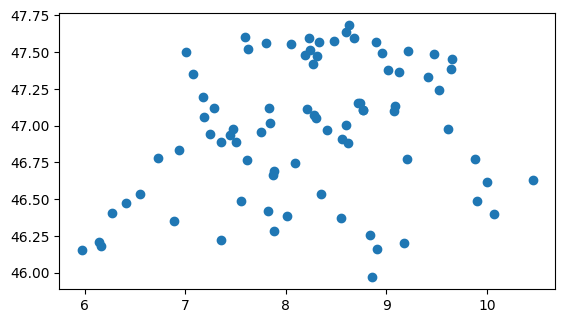

In [43]:
gdf.plot()

In [40]:
gdf

,Operating status,River basin,Stationsnummer,Water body,Station name,Water body type,X-Coordinate,Y-Coordinate,Station altitude [m a.s.l.],Catchment size [km2],Mean catchment altitude [m a.s.l.],Glacial area [%],Measured parameter,Data available from,Data available until,geometry
964,in operation,Rhone,2606,Rhône,"Genève, Halle de l'île",River,2499890,1117850.0,373,8000.0,1658.0,7.2,Discharge,1919-01-01,today,"POLYGON ((5006.14156 -4953.79536, 5006.14156 5..."
852,in operation,Aare,2457,Aare,"Ringgenberg, Goldswil",River,2633731,1171508.0,564,1138.0,1951.0,12.1,Water level,1980-01-01,today,"POLYGON ((5007.87962 -4953.30606, 5007.87962 5..."
863,in operation,Inn,2462,Inn,S-Chanf,River,2795792,1165907.0,1648,616.0,2463.0,6.1,pH value,1999-03-25,today,"POLYGON ((5009.99507 -4953.38429, 5009.99507 5..."
551,in operation,Rhine,2288,Rhein,"Neuhausen, Flurlingerbrücke",River,2689140,1281987.0,388,11930.0,1239.0,0.3,Discharge,1904-01-01,today,"POLYGON ((5008.62579 -4952.31756, 5008.62579 5..."
97,in operation,Aare,2034,Broye,"Payerne, Caserne d'aviation",River,2561671,1187319.0,446,416.0,715.0,0.0,Water temperature,1976-01-01,today,"POLYGON ((5006.93621 -4953.16409, 5006.93621 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,in operation,Etschgebiet,2617,Rom,Müstair,River,2830800,1168706.0,1236,128.0,2184.0,0.0,Water level,1994-05-19,today,"POLYGON ((5010.45316 -4953.37031, 5010.45316 5..."
971,in operation,Limmat,2609,Alp,Einsiedeln,River,2698640,1223035.0,845,46.7,1157.0,0.0,Discharge,1991-02-27,today,"POLYGON ((5008.73928 -4952.84907, 5008.73928 5..."
889,in operation,Rhine,2473,Rhein,"Diepoldsau, Rietbrücke",River,2766305,1250371.0,412,6299.0,1771.0,0.6,pH value,1976-01-01,today,"POLYGON ((5009.64124 -4952.61684, 5009.64124 5..."
533,in operation,Reuss,2276,Grosstalbach,Isenthal,River,2685505,1196051.0,765,43.9,1819.0,6.7,Water temperature,2004-02-19,today,"POLYGON ((5008.56102 -4953.08994, 5008.56102 5..."


#### Plot all cells

<Axes: >

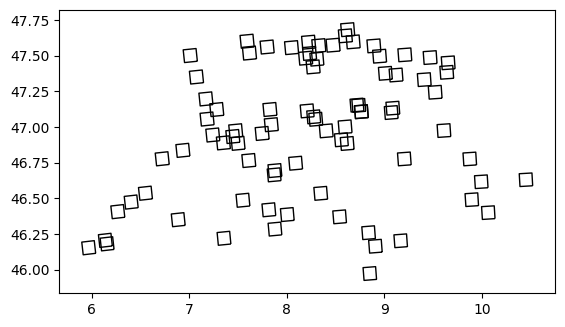

In [52]:
gdf = gdf.to_crs("EPSG:32633")
buffer_size = 5000  # 10x10 km significa 5 km de radio en cada dirección desde el centro

# Función para crear una celda cuadrada alrededor de cada punto
def create_square(point, size):
    x, y = point.x, point.y
    return box(x - size, y - size, x + size, y + size)

# Aplicamos la función a cada punto en el GeoDataFrame
gdf['geometry'] = gdf.geometry.apply(lambda point: create_square(point, buffer_size))
gdf = gdf.to_crs("EPSG:4326")
gdf.plot(color='none')
# Guardamos el resultado como un shapefile
#gdf.to_file("estaciones_10x10km_cells.shp", driver="ESRI Shapefile")

#### Create a shp for each cell

In [51]:
# Change the CRS to a projected coordinate system (e.g., UTM appropriate for your region)
gdf = gdf.to_crs("EPSG:32633")  # Make sure to use the correct CRS for your region

# Define the buffer size in meters (10x10 km = 5000 m in each direction from the center point)
buffer_size = 5000

# Create a folder to store the shapefiles if it doesn't exist
output_folder = "../data/external/shp/cells_10x10km"
os.makedirs(output_folder, exist_ok=True)
c=1
# Iterate over each point and create a 10x10 km cell, saving it as an individual shapefile
for idx, point in gdf.iterrows():
    # Create the square cell
    x, y = point.geometry.x, point.geometry.y
    square = box(x - buffer_size, y - buffer_size, x + buffer_size, y + buffer_size)
    
    # Create a new GeoDataFrame for the cell
    cell_gdf = gpd.GeoDataFrame(index=[0], crs=gdf.crs, geometry=[square])
    
    # Define the filename for each cell, using the index or any relevant attribute
    cell_filename = f"{output_folder}/cell_{c}.shp"
    cell_gdf = cell_gdf.to_crs("EPSG:4326")
    
    # Save the individual cell as a shapefile
    cell_gdf.to_file(cell_filename, driver="ESRI Shapefile")
    c+=1

print("Individual shapefiles created in the 'cells_10x10km' folder.")


Individual shapefiles created in the 'cells_10x10km' folder.


### Comparison to old cells

In [53]:
crs_original = "EPSG:2056"  # o usa "EPSG:21781" si las coordenadas están en LV03

# Convertir el DataFrame de pandas a un GeoDataFrame de geopandas
gdf = gpd.GeoDataFrame(
    new_df,
    geometry=gpd.points_from_xy(new_df["X-Coordinate"], new_df["Y-Coordinate"]),
    crs=crs_original
)

# Proyectar al CRS deseado, por ejemplo WGS84 (EPSG:4326)
gdf = gdf.to_crs("EPSG:4326")

<Axes: >

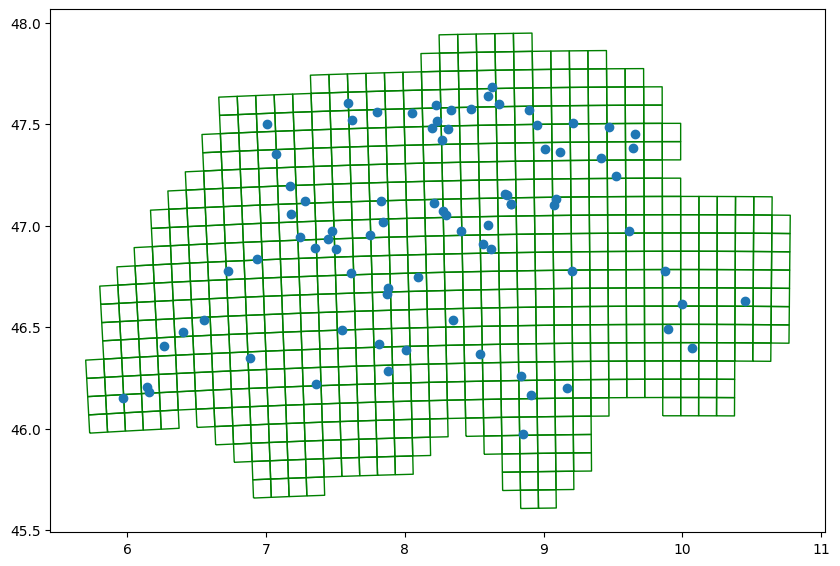

In [54]:
gdf2 = gpd.read_file('../data/external/shp/Switzerland_shapefile')
gdf2 = gdf2.to_crs("EPSG:4326")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf2.plot(ax=ax, facecolor="none", edgecolor="green", linewidth=1, label='Preprocessed Cells')
gdf.plot(ax=ax)
